==============================\
Student name: Shiqi Yin \
GitHub username: acse-sy121\
\==============================

In [ ]:
!pip install tensorflow==2.7.0
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import joblib
import copy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 665.5 MB 19 kB/s 
     |████████████████████████████████| 463 kB 11.5 MB/s 
     |████████████████████████████████| 1.3 MB 58.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.1
    Uninstalling tensorflow-2.9.1:
      Successfully uninstalled tensorflow-2.9.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# PCA model
pca_compress = joblib.load('/content/drive/MyDrive/output_files/DATA/PCA_data/pca_compress_to_92.pkl')
# POD coefficients
train_data = joblib.load('/content/drive/MyDrive/output_files/DATA/PCA_data/X_train_pca.pkl')
print(train_data.shape)

(576, 150)


In [ ]:
train_data

array([[ 8.80486363e+02,  4.12229972e+02,  3.95681246e+00, ...,
        -6.96420993e+00,  4.93415740e+00,  3.52779016e+00],
       [ 8.75527584e+02,  4.04940774e+02,  1.04710778e+01, ...,
         3.92726780e+00, -2.26658068e+00, -3.06227426e+00],
       [ 8.72281335e+02,  4.01970858e+02,  3.39819939e+01, ...,
         5.41922985e+00,  1.70541213e+00,  5.61786257e+00],
       ...,
       [-4.91745149e+02,  7.73314021e+01, -1.15152567e+00, ...,
        -9.09437401e-01, -2.57594235e+00,  4.43025032e+00],
       [-4.91767096e+02,  7.68693790e+01,  5.02940256e+00, ...,
        -1.61047777e-01,  2.04845450e+01,  6.76800410e+00],
       [-4.93904653e+02,  7.28145386e+01,  1.64911295e+01, ...,
         2.14301294e+00, -1.01158558e+01,  9.57896778e+00]])

In [ ]:
# Parameters
input_timestamps = 9
batchsize = 128
latent_space = 350
step = 1

In [ ]:
scaler_minmax = MinMaxScaler((0,1))
scaler_minmax.fit(train_data)
X_train_array_origin = scaler_minmax.transform(train_data)

In [ ]:
def simplify_dataset(X_train, input_timestamps, step):
  X_train_simp = []
  for i in range(len(X_train) - input_timestamps*step):
    X_train_simp.append(X_train[i:i+input_timestamps*step:step])
  return np.array(X_train_simp) 

In [ ]:
X_train_array = simplify_dataset(X_train_array_origin, input_timestamps, step)
print(X_train_array.shape)

(567, 9, 150)


In [ ]:
def Data_reshape(input_array):
  X_for_conv = (input_array.reshape((input_array.shape[0], input_timestamps, input_array.shape[2], 1))).astype('float32')
  X_output = tf.data.Dataset.from_tensor_slices(X_for_conv)
  X_output = X_output.shuffle(len(X_output))
  X_output = X_output.batch(batchsize)
  print(X_for_conv.shape)
  return X_for_conv, X_output

In [ ]:
X_train_for_conv, X_train = Data_reshape(X_train_array)

(567, 9, 150, 1)


In [ ]:
def make_encoder_model():
  model = keras.Sequential()
  model.add(keras.layers.Conv2D(48, (3, 3), input_shape = (input_timestamps, train_data.shape[1], 1), padding='same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())
  model.add(keras.layers.Dropout(0.2))

  model.add(keras.layers.Conv2D(24, (3, 3), padding='same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())
  model.add(keras.layers.Dropout(0.2))

  model.add(keras.layers.Conv2D(4, (3, 3), padding='same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())
  model.add(keras.layers.Dropout(0.2))

  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(latent_space))

  return model

def make_decoder_model():
  model = keras.Sequential()
  model.add(keras.layers.Dense(X_train_for_conv.shape[1]*X_train_for_conv.shape[2]*4, use_bias=False, activation = 'relu', input_shape = (latent_space,)))
  model.add(keras.layers.Reshape((input_timestamps, train_data.shape[1], 4)))

  model.add(keras.layers.Conv2DTranspose(24, (3, 3), padding = 'same', use_bias=False))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())

  model.add(keras.layers.Conv2DTranspose(48, (3, 3), padding = 'same', use_bias=False))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())

  model.add(keras.layers.Conv2DTranspose(1, (3, 3), padding = 'same', output_padding=[0,0], use_bias=False, activation='sigmoid'))

  return model

In [ ]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(keras.layers.Dense(512, activation="relu", input_shape=(latent_space,)))
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.Dense(256, activation="relu"))
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.Dense(96, activation="relu"))
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.Dense(1))

  return model

In [ ]:
encoder = make_encoder_model()
encoder.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 9, 150, 48)        480       
                                                                 
 batch_normalization_25 (Bat  (None, 9, 150, 48)       192       
 chNormalization)                                                
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 9, 150, 48)        0         
                                                                 
 dropout_30 (Dropout)        (None, 9, 150, 48)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 9, 150, 24)        10392     
                                                                 
 batch_normalization_26 (Bat  (None, 9, 150, 24)       96        
 chNormalization)                                    

In [ ]:
decoder = make_decoder_model()
decoder.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 5400)              1890000   
                                                                 
 reshape_5 (Reshape)         (None, 9, 150, 4)         0         
                                                                 
 conv2d_transpose_15 (Conv2D  (None, 9, 150, 24)       864       
 Transpose)                                                      
                                                                 
 batch_normalization_28 (Bat  (None, 9, 150, 24)       96        
 chNormalization)                                                
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 9, 150, 24)        0         
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 9, 150, 48)     

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 512)               179712    
                                                                 
 dropout_33 (Dropout)        (None, 512)               0         
                                                                 
 dense_33 (Dense)            (None, 256)               131328    
                                                                 
 dropout_34 (Dropout)        (None, 256)               0         
                                                                 
 dense_34 (Dense)            (None, 96)                24672     
                                                                 
 dropout_35 (Dropout)        (None, 96)                0         
                                                                 
 dense_35 (Dense)            (None, 1)               

In [ ]:
autoencoder = keras.Sequential([encoder, decoder])
autoencoder.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_25 (Sequential)  (None, 350)               1902394   
                                                                 
 sequential_26 (Sequential)  (None, 9, 150, 1)         1901952   
                                                                 
Total params: 3,804,346
Trainable params: 3,804,050
Non-trainable params: 296
_________________________________________________________________


In [ ]:
encoder_disc = keras.Sequential([encoder, discriminator])
encoder_disc.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_25 (Sequential)  (None, 350)               1902394   
                                                                 
 sequential_27 (Sequential)  (None, 1)                 335809    
                                                                 
Total params: 2,238,203
Trainable params: 2,238,051
Non-trainable params: 152
_________________________________________________________________


In [ ]:
# After grid search, Adam is choosen because it performs the best

a_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005) 

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse = tf.keras.losses.MeanSquaredError()
@tf.function
def compute_autoencoder_loss(x, x_logit):
    """
    Calculate mean square error 
    between the input of the encoder 
    and the output of the decoder 
    
    Parameters
    ----------
    x : Tensor 
      the input of the encoder
    x_logit : Tensor
      the output of the decoder

    Returns
    -------
    Tensor
      mean squared loss between x and x_logit
    """  
    autoencoder_loss = mse(x, x_logit)
    return autoencoder_loss

@tf.function
def compute_discriminator_loss(fake_output, real_output):
    """
    Calculate cross entropy loss 
    between random noise and one, 
    the output of the encoder and zero 
    
    Parameters
    ----------
    fake_output : Tensor 
      the result of the discriminator 
      on the output of the encoder 
    real_output : Tensor
      the result of the discriminator 
      on the output of random noise
      
    Returns
    -------
    Tensor
      the discrimination result
      on the output of the encoder and random noise
    """  
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

@tf.function
def compute_decoder_loss(fake_output):
    """
    Calculate cross entropy loss 
    between the output of the encoder and one 
    
    Parameters
    ----------
    fake_output : Tensor 
      the result of the discriminator 
      on the output of the encoder 
      
    Returns
    -------
    Tensor
      the cross entropy loss
      between the output of the encoder and one 
    """    
    return cross_entropy(tf.ones_like(fake_output), fake_output)

autoencoder_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
decoder_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
discriminator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)

In [ ]:
@tf.function
def train_step(batch):
    # Autoencoder update
    with tf.GradientTape() as ae_tape:
        encoder_output = encoder(batch, training=True)
        decoder_output = decoder(encoder_output, training=True)
        autoencoder_loss = compute_autoencoder_loss(batch, decoder_output)

    a_gradients = ae_tape.gradient(autoencoder_loss, encoder.trainable_variables + decoder.trainable_variables)
    a_optimizer.apply_gradients(zip(a_gradients, encoder.trainable_variables + decoder.trainable_variables))

    # Discriminator update
    with tf.GradientTape() as d_tape:
        z = encoder(batch, training=True)
        true_z = tf.random.normal(shape=(z.shape))
        fake_output = discriminator(z, training=True)
        true_output = discriminator(true_z, training=True)
        discriminator_loss = compute_discriminator_loss(fake_output, true_output)
    d_gradients = d_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

    # Decoder update
    with tf.GradientTape() as g_tape:
        z = encoder(batch, training=True)
        fake_output = discriminator(z, training=True)
        decoder_loss = compute_decoder_loss(fake_output)
    g_gradients = g_tape.gradient(decoder_loss, encoder.trainable_variables)
    g_optimizer.apply_gradients(zip(g_gradients, encoder.trainable_variables))

    autoencoder_mean_loss(autoencoder_loss)
    decoder_mean_loss(decoder_loss)
    discriminator_mean_loss(discriminator_loss)

In [ ]:
def train(dataset, epochs):
    hist = []
    aeloss = []
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch + 1, epochs))   
        for batch in dataset:
          train_step(batch)

        hist.append([decoder_mean_loss.result().numpy(), discriminator_mean_loss.result().numpy()])
        aeloss.append(autoencoder_mean_loss.result().numpy())

        # Resets metric state variables.
        decoder_mean_loss.reset_states()
        discriminator_mean_loss.reset_states()
        autoencoder_mean_loss.reset_states()

        print("encoder loss: ", hist[-1][0]," - ", "discriminator loss: ", hist[-1][1])
        print("autoencoder loss: ", aeloss[-1])
        
        if epoch > 0 and (epoch+1)%1000 == 0:
            # Plot loss
            print('Loss: ')
            fig, ax = plt.subplots(1,1, figsize=[20,10])
            ax.plot(hist)
            ax.legend(['loss_enc', 'loss_disc'])
            ax.grid()
            plt.show()
        
    return hist, aeloss

In [ ]:
hist, autoencoder_loss = train(X_train, epochs=10000)

In [ ]:
a = copy.deepcopy(hist)
losses = copy.deepcopy(hist)
a = np.array(a)
print(a.shape)
print(autoencoder_loss[0])
for i in range(len(hist)):
  losses[i].append(autoencoder_loss[i])

losses_arr = np.array(losses)
losses_arr.shape

(8000, 2)
0.07357219


(8000, 3)

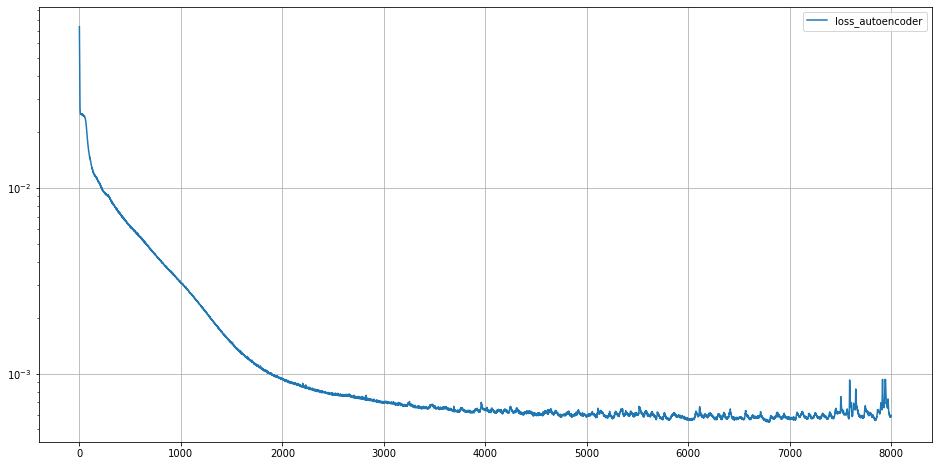

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[16,8])
ax.plot(autoencoder_loss)
ax.legend(['loss_autoencoder'])
ax.set_yscale('log')
ax.grid()
plt.savefig("/content/drive/MyDrive/output_files/Figures/Figures_without_DA/Training/autoencoder_loss.png")

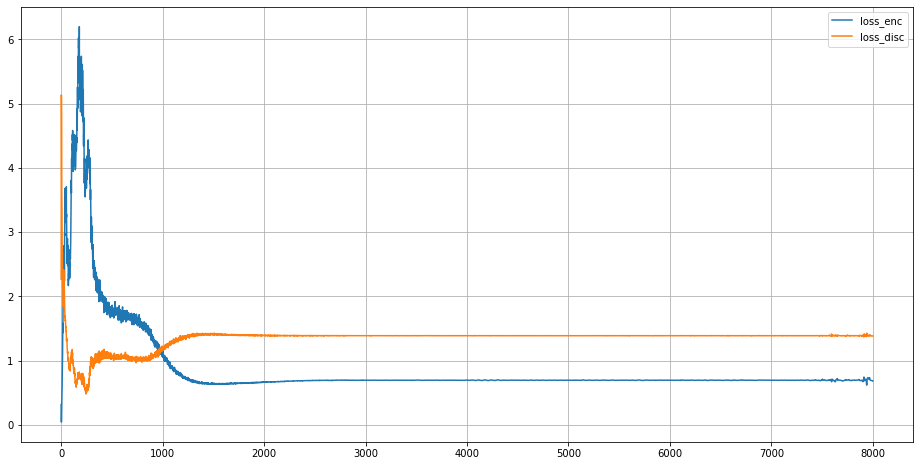

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[16,8])
ax.plot(hist)
ax.legend(['loss_enc', 'loss_disc'])
ax.grid()
plt.savefig("/content/drive/MyDrive/output_files/Figures/Figures_without_DA/Training/enc_disc_loss.png")

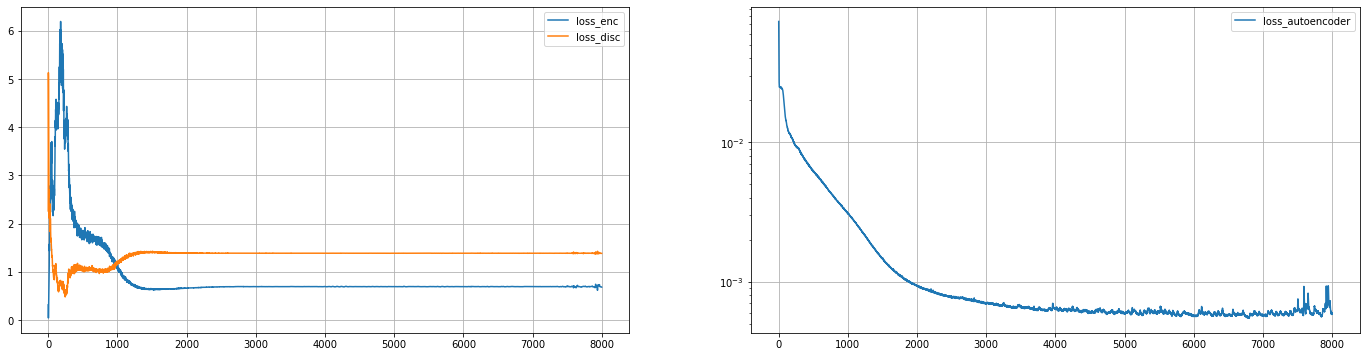

In [ ]:
fig, ax = plt.subplots(1,2, figsize=[24,6])
ax[0].plot(hist)
ax[0].legend(['loss_enc', 'loss_disc'])
ax[0].grid()
ax[1].plot(autoencoder_loss)
ax[1].legend(['loss_autoencoder'])
ax[1].set_yscale('log')
ax[1].grid()

plt.savefig("/content/drive/MyDrive/output_files/Figures/Figures_without_DA/Training/losses.png")

In [ ]:
joblib.dump(scaler_minmax, '/content/drive/MyDrive/output_files/scalers/node_data/scaler_without_DA/scaler_minmax01.pkl')
autoencoder.save('/content/drive/MyDrive/output_files/Models/without_sensor/autoencoder_default.h5')
encoder_disc.save('/content/drive/MyDrive/output_files/Models/without_sensor/encoder_disc_default.h5')